
[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: C:\Users\priya\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


Dataset Path: data\yes
Total Images: 155

Processing Images...

Y1.jpg                    | Otsu Dice: 0.3229 | Sauvola Dice: 0.2606 | Otsu Jaccard: 0.1925 | Sauvola Jaccard: 0.1499
Y10.jpg                   | Otsu Dice: 0.4782 | Sauvola Dice: 0.4349 | Otsu Jaccard: 0.3142 | Sauvola Jaccard: 0.2778
Y100.JPG                  | Otsu Dice: 0.0465 | Sauvola Dice: 0.0397 | Otsu Jaccard: 0.0238 | Sauvola Jaccard: 0.0203
Y101.jpg                  | Otsu Dice: 0.1426 | Sauvola Dice: 0.1232 | Otsu Jaccard: 0.0768 | Sauvola Jaccard: 0.0656
Y102.jpg                  | Otsu Dice: 0.2142 | Sauvola Dice: 0.1589 | Otsu Jaccard: 0.1200 | Sauvola Jaccard: 0.0863
Y103.jpg                  | Otsu Dice: 0.4293 | Sauvola Dice: 0.3235 | Otsu Jaccard: 0.2733 | Sauvola Jaccard: 0.1929
Y104.jpg                  | Otsu Dice: 0.9094 | Sauvola Dice: 0.3927 | Otsu Jaccard: 0.8339 | Sauvola Jaccard: 0.2444
Y105.jpg                  | Otsu Dice: 0.7160 | Sauvola Dice: 0.7299 | Otsu Jaccard: 0.5577 | Sauvola Jaccard:

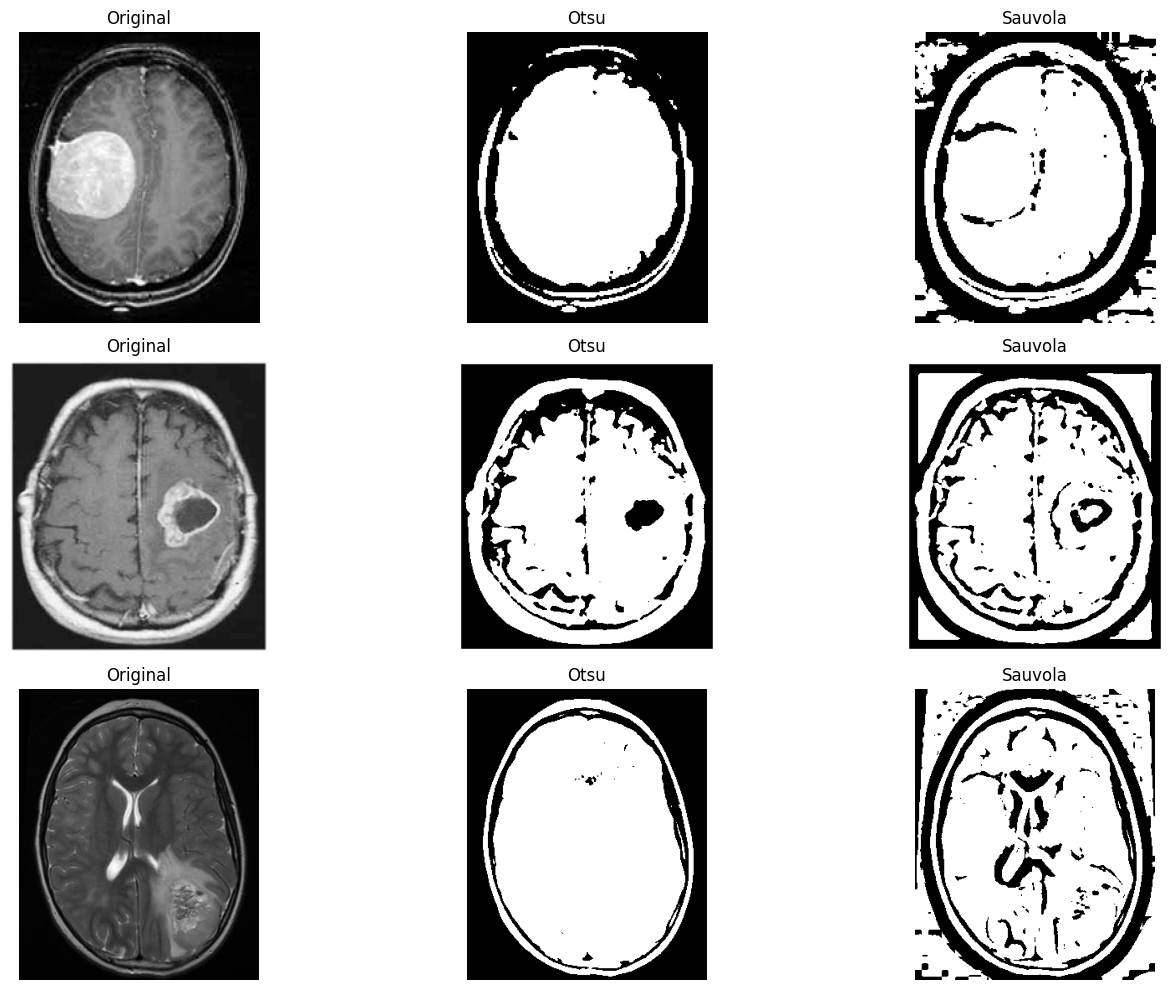

In [1]:
# =====================================
# Brain MRI Tumor Segmentation
# Otsu vs Sauvola (Local Version)
# =====================================

# Install libraries (run once)
!pip install opencv-python scikit-image scikit-learn matplotlib numpy


# -------------------------------
# Imports
# -------------------------------
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_sauvola
from sklearn.metrics import jaccard_score


# -------------------------------
# Dataset Path (LOCAL)
# -------------------------------
DATA_PATH = "data"
YES_PATH = os.path.join(DATA_PATH, "yes")

print("Dataset Path:", YES_PATH)
print("Total Images:", len(os.listdir(YES_PATH)))


# -------------------------------
# Preprocessing
# -------------------------------
def preprocess(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    return blur


# -------------------------------
# Otsu Thresholding
# -------------------------------
def otsu_seg(img):
    _, th = cv2.threshold(
        img, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    return th


# -------------------------------
# Sauvola Thresholding
# -------------------------------
def sauvola_seg(img):
    thresh = threshold_sauvola(img, window_size=25)
    binary = img > thresh
    return (binary * 255).astype(np.uint8)


# -------------------------------
# Pseudo Ground Truth
# -------------------------------
def pseudo_gt(img):
    _, th = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
    return th


# -------------------------------
# Dice Score
# -------------------------------
def dice_score(a, b):
    a = a.flatten() > 0
    b = b.flatten() > 0

    inter = np.sum(a & b)

    return (2*inter) / (np.sum(a) + np.sum(b) + 1e-8)


# -------------------------------
# Jaccard Index
# -------------------------------
def jaccard(a, b):
    a = a.flatten() > 0
    b = b.flatten() > 0

    return jaccard_score(a, b)


# -------------------------------
# Run Experiment (ALL IMAGES)
# -------------------------------
images = os.listdir(YES_PATH)

dice_otsu = []
dice_sauv = []

jac_otsu = []
jac_sauv = []

print("\nProcessing Images...\n")

for name in images:

    path = os.path.join(YES_PATH, name)
    img = cv2.imread(path)

    if img is None:
        continue

    pre = preprocess(img)

    otsu = otsu_seg(pre)
    sauv = sauvola_seg(pre)

    gt = pseudo_gt(pre)

    # Compute scores
    d_otsu = dice_score(otsu, gt)
    d_sauv = dice_score(sauv, gt)
    
    j_otsu = jaccard(otsu, gt)
    j_sauv = jaccard(sauv, gt)
    
    # Store scores
    dice_otsu.append(d_otsu)
    dice_sauv.append(d_sauv)
    
    jac_otsu.append(j_otsu)
    jac_sauv.append(j_sauv)

# Print per-image result
    print(f"{name:25s} | "
          f"Otsu Dice: {d_otsu:.4f} | "
          f"Sauvola Dice: {d_sauv:.4f} | "
          f"Otsu Jaccard: {j_otsu:.4f} | "
          f"Sauvola Jaccard: {j_sauv:.4f}")


print("Processing Completed ✅")


# -------------------------------
# Print Results
# -------------------------------
avg_dice_otsu = np.mean(dice_otsu)
avg_dice_sauv = np.mean(dice_sauv)

avg_jac_otsu = np.mean(jac_otsu)
avg_jac_sauv = np.mean(jac_sauv)

print("\n========== FINAL RESULTS ==========\n")

print(f"Otsu Average Dice Score    : {avg_dice_otsu:.4f}")
print(f"Sauvola Average Dice Score : {avg_dice_sauv:.4f}\n")

print(f"Otsu Average Jaccard Index : {avg_jac_otsu:.4f}")
print(f"Sauvola Average Jaccard    : {avg_jac_sauv:.4f}")

print("\n===================================")


# -------------------------------
# Visualization (3 Samples)
# -------------------------------
plt.figure(figsize=(15,10))

for i, name in enumerate(images[:3]):

    img = cv2.imread(os.path.join(YES_PATH, name))
    pre = preprocess(img)

    otsu = otsu_seg(pre)
    sauv = sauvola_seg(pre)

    plt.subplot(3,3,i*3+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(3,3,i*3+2)
    plt.imshow(otsu, cmap='gray')
    plt.title("Otsu")
    plt.axis("off")

    plt.subplot(3,3,i*3+3)
    plt.imshow(sauv, cmap='gray')
    plt.title("Sauvola")
    plt.axis("off")

plt.tight_layout()
plt.show()
